In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/README.md
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_24.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_26.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_21.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_23.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_19.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_09.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_27.csv
/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/detections_index_2020_03_03.csv
/kaggle/

In [2]:
# === Step 0: Setup & Config ===
import os
import glob
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import List, Tuple

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# ---- Configure your paths here ----
RM_PATH_GLOB = "/kaggle/input/traffic-dats/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm/*.csv"   # e.g., "/data/huawei/RM/*.csv"

# Core parameters
TIME_WINDOW = "5min"    # aggregation window
LAG_STEPS = [1, 2, 3, 6, 12]  # with 5-min windows -> up to 60 min history
ROLL_WINDOWS = [3, 6, 12]     # rolling statistics windows (in 5-min steps)
FORECAST_HORIZONS = [1, 3]    # predict t+1 (5 min ahead), t+3 (15 min ahead)

RANDOM_STATE = 42

@dataclass
class SplitBoundaries:
    train_end: pd.Timestamp
    val_end: pd.Timestamp
    # test is everything > val_end


In [3]:
import pandas as pd
import glob
import os

# Path to RM folder
folder_path = "/kaggle/input/traffic-data/omlstreaming-mrc-traffic-detection-dataset-97f954e/rm"
# Column names from dataset description
columns = [
    "anonymized_car_plate",
    "startDate",
    "startTime",
    "endDate",
    "endTime",
    "leaving_edge",
    "intersection",
    "incoming_edge"
]

# Load and combine
all_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = []
for file in all_files:
    df = pd.read_csv(file, names=columns, header=None)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

# Combine start date and time into a datetime
data["start_datetime"] = pd.to_datetime(data["startDate"] + " " + data["startTime"])
data["end_datetime"] = pd.to_datetime(data["endDate"] + " " + data["endTime"])

print("Data shape:", data.shape)
print(data.head())


Data shape: (2894174, 10)
                                anonymized_car_plate   startDate startTime  \
0  ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...  2020/03/24  15:58:43   
1  ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...  2020/03/24  16:19:20   
2  ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...  2020/03/24  16:26:45   
3  8491db205f83896f4aee0554651d7038d53ff70d12f23b...  2020/03/24  16:19:20   
4  8491db205f83896f4aee0554651d7038d53ff70d12f23b...  2020/03/24  16:20:58   

      endDate   endTime  leaving_edge  intersection  incoming_edge  \
0  2020/03/24  15:58:44      16685124        761467       16685136   
1  2020/03/24  16:19:21        991036        761368         895895   
2  2020/03/24  16:26:46        991036        761368         895898   
3  2020/03/24  16:19:21        991036        761368         895895   
4  2020/03/24  16:20:59      88098875        763080       88098867   

       start_datetime        end_datetime  
0 2020-03-24 15:58:43 2020-03-24 15:58:4

In [4]:
data.head()

,anonymized_car_plate,startDate,startTime,endDate,endTime,leaving_edge,intersection,incoming_edge,start_datetime,end_datetime
0,ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...,2020/03/24,15:58:43,2020/03/24,15:58:44,16685124,761467,16685136,2020-03-24 15:58:43,2020-03-24 15:58:44
1,ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...,2020/03/24,16:19:20,2020/03/24,16:19:21,991036,761368,895895,2020-03-24 16:19:20,2020-03-24 16:19:21
2,ba5704a781e60d9b67a90c9eac4fe425bf366ef9bba5ff...,2020/03/24,16:26:45,2020/03/24,16:26:46,991036,761368,895898,2020-03-24 16:26:45,2020-03-24 16:26:46
3,8491db205f83896f4aee0554651d7038d53ff70d12f23b...,2020/03/24,16:19:20,2020/03/24,16:19:21,991036,761368,895895,2020-03-24 16:19:20,2020-03-24 16:19:21
4,8491db205f83896f4aee0554651d7038d53ff70d12f23b...,2020/03/24,16:20:58,2020/03/24,16:20:59,88098875,763080,88098867,2020-03-24 16:20:58,2020-03-24 16:20:59


In [5]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['anonymized_car_plate', 'leaving_edge', 'intersection', 'incoming_edge']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le


/tmp/ipykernel_13/3408790558.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data.set_index('start_datetime').resample('H').size().plot(figsize=(12,6))


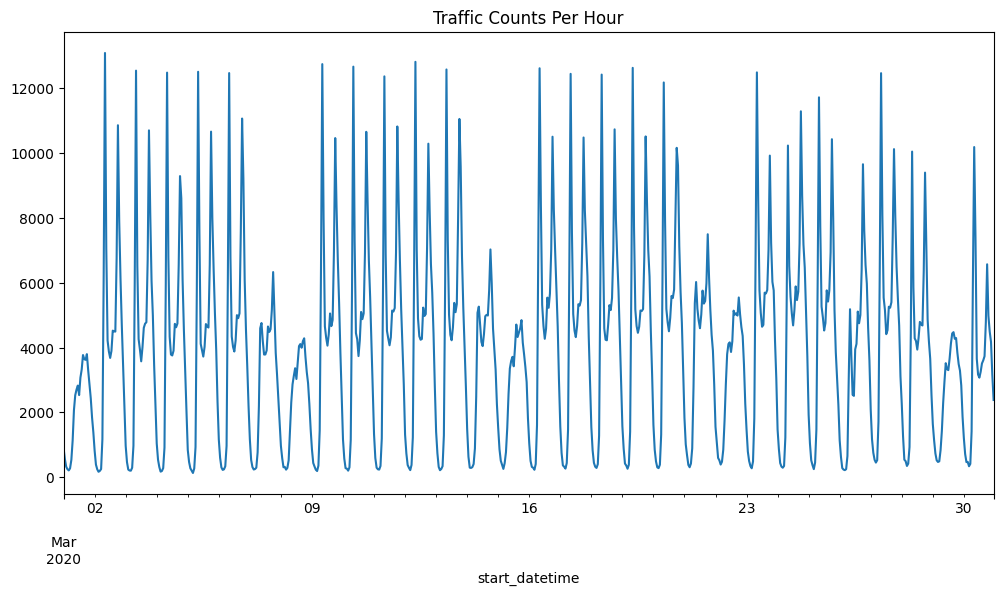

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
data.set_index('start_datetime').resample('H').size().plot(figsize=(12,6))
plt.title("Traffic Counts Per Hour")
plt.show()


In [7]:
data['duration_seconds'] = (data['end_datetime'] - data['start_datetime']).dt.total_seconds()


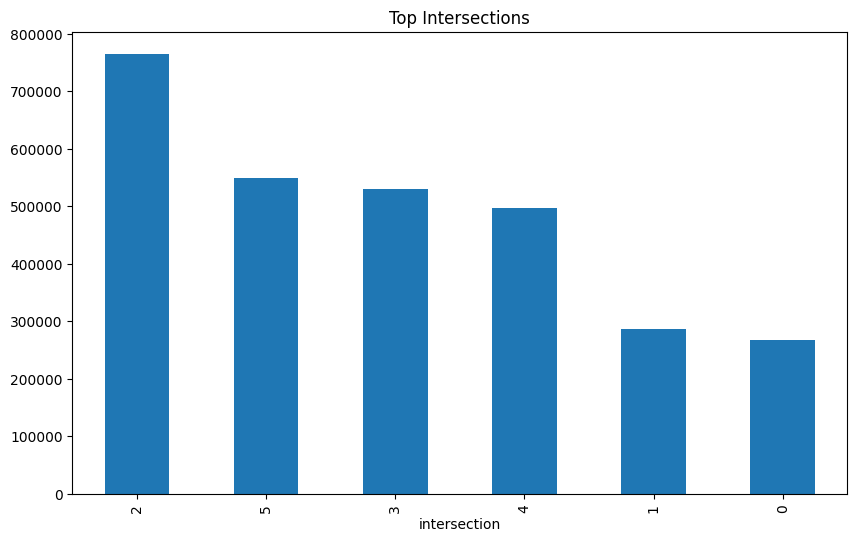

In [8]:
plt.figure(figsize=(10,6))
data['intersection'].value_counts().head(10).plot(kind='bar')
plt.title("Top Intersections")
plt.show()


In [9]:
# import matplotlib.pyplot as plt

# # Plot histogram
# plt.figure(figsize=(10,6))
# plt.hist(vehicle_counts['vehicle_count'], bins=30, edgecolor='black', alpha=0.7)
# plt.axvline(low_th, color='green', linestyle='--', linewidth=2, label=f'Low Threshold ({low_th:.1f})')
# plt.axvline(med_th, color='orange', linestyle='--', linewidth=2, label=f'Medium Threshold ({med_th:.1f})')

# plt.title('Vehicle Count Distribution with Thresholds')
# plt.xlabel('Vehicle Count')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()



Basic statistics:
       anonymized_car_plate  leaving_edge  intersection  incoming_edge  \
count          2.894174e+06  2.894174e+06  2.894174e+06   2.894174e+06   
mean           1.684378e+05  9.617033e+00  2.812478e+00   9.082176e+00   
min            0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%            8.367200e+04  5.000000e+00  2.000000e+00   4.000000e+00   
50%            1.681215e+05  8.000000e+00  3.000000e+00   7.000000e+00   
75%            2.536800e+05  1.700000e+01  4.000000e+00   1.500000e+01   
max            3.370880e+05  2.100000e+01  5.000000e+00   2.100000e+01   
std            9.739125e+04  6.273008e+00  1.544503e+00   6.693440e+00   

                      start_datetime                   end_datetime  \
count                        2894174                        2894174   
mean   2020-03-16 07:33:57.129635328  2020-03-16 07:33:58.130146048   
min              2020-03-01 00:00:01            2020-03-01 00:00:02   
25%    2020-03-09 11:18:28.249

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


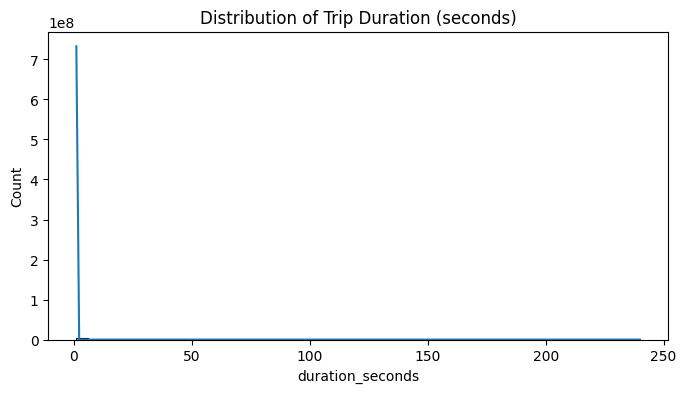


Unique cars: 337089


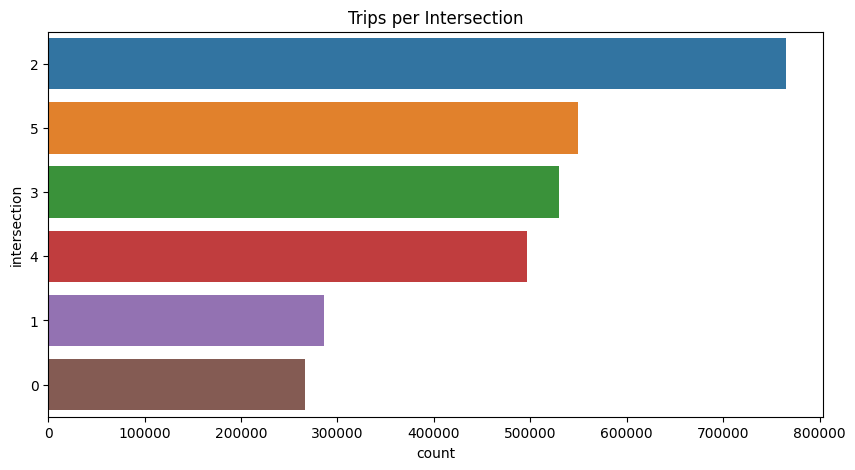

In [10]:
print("\nBasic statistics:")
print(data.describe())

# 7. Plot trip duration distribution
plt.figure(figsize=(8, 4))
sns.histplot(data['duration_seconds'], bins=50, kde=True)
plt.title("Distribution of Trip Duration (seconds)")
plt.show()

# 8. Count of unique cars
print("\nUnique cars:", data['anonymized_car_plate'].nunique())

# 9. Trips per intersection
plt.figure(figsize=(10, 5))
sns.countplot(y='intersection', data=data, order=data['intersection'].value_counts().index)
plt.title("Trips per Intersection")
plt.show()

In [11]:
import pandas as pd

#  Combine date and time into a single datetime column
data['start_datetime'] = pd.to_datetime(data['startDate'] + ' ' + data['startTime'])

#  Define time window (e.g., hourly)
data['time_window'] = data['start_datetime'].dt.floor('H')  # Hourly aggregation

# Count vehicles per intersection per time window
vehicle_counts = (
    data.groupby(['intersection', 'time_window'])
    .size()
    .reset_index(name='vehicle_count')
)

# Define congestion thresholds

low_th = np.percentile(vehicle_counts['vehicle_count'], 33)
med_th = np.percentile(vehicle_counts['vehicle_count'], 66)

def classify_congestion(count):
    if count <= low_th:
        return "Low"
    elif count <= med_th:
        return "Medium"
    else:
        return "High"


vehicle_counts['congestion_level'] = vehicle_counts['vehicle_count'].apply(classify_congestion)

#  Merge back to original data if needed
data = pd.merge(data, vehicle_counts, on=['intersection', 'time_window'], how='left')

#  Encode congestion labels for ML
label_map = {"Low": 0, "Medium": 1, "High": 2}
data['congestion_label'] = data['congestion_level'].map(label_map)

print(data[['intersection', 'time_window', 'vehicle_count', 'congestion_level', 'congestion_label']].head())


/tmp/ipykernel_13/1433208506.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['time_window'] = data['start_datetime'].dt.floor('H')  # Hourly aggregation


   intersection         time_window  vehicle_count congestion_level  \
0             3 2020-03-24 15:00:00           1233             High   
1             1 2020-03-24 16:00:00            530           Medium   
2             1 2020-03-24 16:00:00            530           Medium   
3             1 2020-03-24 16:00:00            530           Medium   
4             4 2020-03-24 16:00:00           1031             High   

   congestion_label  
0                 2  
1                 1  
2                 1  
3                 1  
4                 2  


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#  Feature engineering
data['day_of_week'] = data['time_window'].dt.dayofweek  # Monday=0
data['hour_of_day'] = data['time_window'].dt.hour       # 0-23

# Encode intersection
le_intersection = LabelEncoder()
data['intersection_encoded'] = le_intersection.fit_transform(data['intersection'])

#  Select features and target
X = data[['intersection_encoded', 'day_of_week', 'hour_of_day']]
y = data['congestion_label']

#  Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87     34547
           1       0.86      0.83      0.84    159383
           2       0.94      0.96      0.95    384905

    accuracy                           0.92    578835
   macro avg       0.90      0.88      0.89    578835
weighted avg       0.91      0.92      0.91    578835


Confusion Matrix:
 [[ 29152   5370     25]
 [  3241 132896  23246]
 [     0  17127 367778]]


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,       # number of trees
    max_depth=6,           # depth of each tree
    learning_rate=0.1,     # step size shrinkage
    subsample=0.8,         # use 80% of data for each tree
    colsample_bytree=0.8,  # use 80% of features per tree
    random_state=42,
    eval_metric='mlogloss' # for multi-class classification
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9117054082769701

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87     34547
           1       0.84      0.84      0.84    159383
           2       0.94      0.95      0.95    384905

    accuracy                           0.91    578835
   macro avg       0.89      0.88      0.88    578835
weighted avg       0.91      0.91      0.91    578835


Confusion Matrix:
 [[ 29046   5476     25]
 [  3553 133828  22002]
 [     0  20052 364853]]


In [14]:
import pandas as pd
import numpy as np

# Ensure we have the hourly (or whatever) window and counts
# If you've already created vehicle_counts earlier and merged back, we’ll (re)aggregate to be safe.
ts = (
    data
    .groupby(['intersection','time_window'])
    .size()
    .rename('vehicle_count')
    .reset_index()
    .sort_values(['intersection','time_window'])
)

print(ts.head(), ts.shape)


   intersection         time_window  vehicle_count
0             0 2020-03-01 00:00:00             77
1             0 2020-03-01 01:00:00             49
2             0 2020-03-01 02:00:00             25
3             0 2020-03-01 03:00:00             17
4             0 2020-03-01 04:00:00             14 (4170, 3)


In [15]:
ts['vehicle_count'].mean()

694.0465227817746

In [16]:
LAGS = [1, 2, 3, 6, 12]        # with hourly windows → up to 12 hours history
ROLLS = [3, 6, 12]             # rolling stats windows
HORIZONS = [1, 3]              # predict t+1 and t+3 steps ahead

def add_features(df):
    def _fe(g):
        g = g.sort_values('time_window').copy()
        # lags
        for L in LAGS:
            g[f'lag_{L}'] = g['vehicle_count'].shift(L)
        # rolling stats (shifted to avoid leakage)
        for W in ROLLS:
            g[f'roll_mean_{W}'] = g['vehicle_count'].shift(1).rolling(W, min_periods=1).mean()
            g[f'roll_std_{W}']  = g['vehicle_count'].shift(1).rolling(W, min_periods=1).std()
            g[f'roll_max_{W}']  = g['vehicle_count'].shift(1).rolling(W, min_periods=1).max()
        # calendar features
        g['hour'] = g['time_window'].dt.hour
        g['dow']  = g['time_window'].dt.dayofweek
        g['hour_sin'] = np.sin(2*np.pi*g['hour']/24.0)
        g['hour_cos'] = np.cos(2*np.pi*g['hour']/24.0)
        g['dow_sin']  = np.sin(2*np.pi*g['dow']/7.0)
        g['dow_cos']  = np.cos(2*np.pi*g['dow']/7.0)
        # future targets
        for h in HORIZONS:
            g[f'y_tplus_{h}'] = g['vehicle_count'].shift(-h)
        return g
    out = df.groupby('intersection', group_keys=False).apply(_fe)
    return out

feat = add_features(ts)


/tmp/ipykernel_13/4199248607.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby('intersection', group_keys=False).apply(_fe)


In [17]:
# Drop rows with any NA in features or targets
feature_cols = (
    [f'lag_{L}' for L in LAGS] +
    sum([[f'roll_mean_{w}', f'roll_std_{w}', f'roll_max_{w}'] for w in ROLLS], []) +
    ['hour_sin','hour_cos','dow_sin','dow_cos']
)

target_cols = [f'y_tplus_{h}' for h in HORIZONS]

clean = feat.dropna(subset=feature_cols + target_cols).copy()

# Temporal boundaries: 70% train, 15% val, 15% test by global time
all_times = np.sort(clean['time_window'].unique())
t_train_end = all_times[int(0.7*len(all_times))-1]
t_val_end   = all_times[int(0.85*len(all_times))-1]

train_mask = clean['time_window'] <= t_train_end
val_mask   = (clean['time_window'] > t_train_end) & (clean['time_window'] <= t_val_end)
test_mask  = clean['time_window'] > t_val_end

print("Train end:", t_train_end, "| Val end:", t_val_end)


Train end: 2020-03-22T00:00:00.000000000 | Val end: 2020-03-26T10:00:00.000000000


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)

models = {}
for h in HORIZONS:
    y_tr = clean.loc[train_mask, f'y_tplus_{h}']
    y_va = clean.loc[val_mask,   f'y_tplus_{h}']
    y_te = clean.loc[test_mask,  f'y_tplus_{h}']

    X_tr = clean.loc[train_mask, feature_cols]
    X_va = clean.loc[val_mask,   feature_cols]
    X_te = clean.loc[test_mask,  feature_cols]

    reg = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )
    reg.fit(X_tr, y_tr)
    models[h] = reg

    # eval
    pred_va = reg.predict(X_va)
    pred_te = reg.predict(X_te)

    print(f"\n=== Horizon t+{h} ===")
    print("VAL: RMSE:", rmse(y_va, pred_va), " MAE:", mean_absolute_error(y_va, pred_va))
    print("TEST: RMSE:", rmse(y_te, pred_te), " MAE:", mean_absolute_error(y_te, pred_te))



=== Horizon t+1 ===
VAL: RMSE: 179.16251892235724  MAE: 96.88313811188812
TEST: RMSE: 228.54082985645536  MAE: 134.39468181818182

=== Horizon t+3 ===
VAL: RMSE: 225.57482638688992  MAE: 121.14007867132867
TEST: RMSE: 278.69027618426  MAE: 167.93814545454543


In [19]:
# thresholds from TRAIN vehicle_count distribution
train_counts = clean.loc[train_mask, 'vehicle_count']
q33 = np.percentile(train_counts, 33)
q66 = np.percentile(train_counts, 66)

def flow_to_class(x, q33=q33, q66=q66):
    if x <= q33: return 0
    elif x <= q66: return 1
    else: return 2

for h, reg in models.items():
    X_te = clean.loc[test_mask, feature_cols]
    y_true_flow_future = clean.loc[test_mask, f'y_tplus_{h}']
    y_pred_flow_future = reg.predict(X_te)

    y_true_cls = [flow_to_class(v) for v in y_true_flow_future]
    y_pred_cls = [flow_to_class(v) for v in y_pred_flow_future]

    from sklearn.metrics import accuracy_score, f1_score
    print(f"\nFuture congestion via forecast — t+{h}")
    print(" Acc:", accuracy_score(y_true_cls, y_pred_cls),
          " F1(macro):", f1_score(y_true_cls, y_pred_cls, average='macro'))



Future congestion via forecast — t+1
 Acc: 0.8781818181818182  F1(macro): 0.8774550450359149

Future congestion via forecast — t+3
 Acc: 0.8436363636363636  F1(macro): 0.8435007158021639


In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Assume df['traffic_flow'] is your series
scaler = MinMaxScaler()
traffic_scaled = scaler.fit_transform(data[['vehicle_count']])

# function to create sequences
def create_sequences(data, past_steps=24, future_steps=3):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps + 1):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

# prepare data
PAST_STEPS = 24  # using last 24 time steps
FUTURE_STEPS = 3 # predicting t+1, t+2, t+3
X, y = create_sequences(traffic_scaled, PAST_STEPS, FUTURE_STEPS)

# train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(PAST_STEPS, 1)),
    Dense(FUTURE_STEPS)  # output is multi-step forecast
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1)


2025-08-25 16:39:20.474737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756139960.713135      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756139960.778633      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 16:39:41.697601: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

Epoch 1/3
65119/65119 ━━━━━━━━━━━━━━━━━━━━ 795s 12ms/step - loss: 0.0320 - val_loss: 0.0384
Epoch 2/3
65119/65119 ━━━━━━━━━━━━━━━━━━━━ 804s 12ms/step - loss: 0.0313 - val_loss: 0.0384
Epoch 3/3
65119/65119 ━━━━━━━━━━━━━━━━━━━━ 805s 12ms/step - loss: 0.0312 - val_loss: 0.0383


In [21]:
y_pred = model.predict(X_test)

# invert scaling
y_pred_inv = scaler.inverse_transform(
    np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1)
)[:, :FUTURE_STEPS]

y_test_2d = y_test.reshape(y_test.shape[0], y_test.shape[1] * y_test.shape[2])  # (578830, 3)

# Concatenate zeros for the missing columns scaler expects
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test_2d, np.zeros((y_test_2d.shape[0], 1))), axis=1)
)[:, :FUTURE_STEPS]

18089/18089 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for step in range(FUTURE_STEPS):
    mae = mean_absolute_error(y_test_inv[:, step], y_pred_inv[:, step])
    rmse = mean_squared_error(y_test_inv[:, step], y_pred_inv[:, step], squared=False)
    print(f"Horizon t+{step+1}: MAE={mae:.2f}, RMSE={rmse:.2f}")


Horizon t+1: MAE=375.33, RMSE=495.96
Horizon t+2: MAE=408.55, RMSE=527.06
Horizon t+3: MAE=413.38, RMSE=534.33
